### Jason's First Tensorflow Project
Acknowledgement: Thanks for helping me understand how/why we chose this model architecture, and how to actually build this, to my friend Xavier. :-) 

https://stackoverflow.com/questions/54778630/could-not-install-packages-due-to-an-environmenterror-errno-2-no-such-file-or

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print("X_Train's Shape: (Before Re-shaping) ", X_train.shape, "\n" )

# Since there is only 1 channel, (brightness of pixel) we reshape the X_train & X_test tensors to 1 channel

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

print("X_Train's Shape: (After Re-shaping) ", X_train.shape )


X_Train's Shape: (Before Re-shaping)  (60000, 28, 28) 

X_Train's Shape: (After Re-shaping)  (60000, 28, 28, 1)


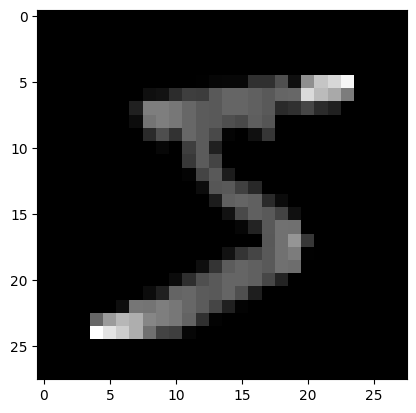

Associated Label :  5


In [2]:
#Normalizing Data:

# - Types are now float32 and normalized from 0 to 1 values (avoid negatives or other weird stuff in dataset)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 0 -> 255 to 0 -> 1 (Normalized in terms of a percentage)
X_train = tf.keras.utils.normalize(X_train, axis=1)  # scales data between 0 and 1
X_test = tf.keras.utils.normalize(X_test, axis=1)  # scales data between 0 and 1


#Display something with matplotlib:
#Grab first image from training dataset & convert to np array of floats
first_image = X_train[0]
first_image = np.array(first_image, dtype='float')

pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print("Associated Label : " , Y_train[0])

#### Now let's pre-process the Labels aswell
- keras [utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) is used like: `to_categorical(dataset, num_classes)` This will define the amount of unique class labels **(A.K.A Unique Categorical Attrib)** to `num_classes` integer 

In [3]:
print( Y_train[:10] )
#And there’s the problem. The y_train and y_test data are not split into 10 distinct class labels, 
#but rather are represented as a single array with the class values.

Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

print( "Y_Train's Shape: (after pre-processing)", Y_train.shape )

[5 0 4 1 9 2 1 3 1 4]
Y_Train's Shape: (after pre-processing) (60000, 10)


### Defining the Model:

The `28 x 28` image will be convoluted to extract features from kernels of **n** size. (n here refers to the amount of time the image is split vertically & horizontally, then calculated with the kernel matrix that the **NN** decides) from here the layers are pooled, then pipelined thru some dense layers.

**Model type & Input Shape:**

- I've chosen the `Sequential` Model, which indicates that this model only feed's forward from input to output. This works for our application since we don't need to go back and retrieve additional info.
- `input_shape` refers to how **Input Layer** data is represented, in this case we've got a 2D tensor with 1 channel that we're feeding into our 2D Convolution layer. So we'll shape the data based on 2 dimensions X & Y which are both 28, and 1 channel *(brightness).* `input_shape(28,28,1)`

**keras [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) (Convolution) Layer:**

- Here i'm using Convolution layers to gather features from the Image, by splitting up the image into sub-sections, and applying a learnt matrix *(This is what the NN learns)* to simply the input data whilst still skewing it into the right direction. (Or in training, optimizing for this correct direction)

- By gathering a convoluted value from a matrix operation, I've gathered a so called **Feature** , this could indicate if the sub-section was a straight line, diagonal or something. (This is how the popular **Canny** Edge Detection Algorithm is implemented, they essentially convolute the image with an [*Gaussian Kernel(s)*](https://automaticaddison.com/how-the-canny-edge-detector-works/#:~:text=More%20formally%2C%20in%20step%201%20of%20the%20Canny,example%205%C3%975%20Gaussian%20kernel%20that%20can%20be%20used.) )

- Here i'm use Convolution layers like so: `tf.keras.layers.Conv2D(n_filters, kernel_size_tuple, activation='relu')`

**keras Max Pooling (MaxPool2D) Layer:**

[Cool MaxPooling2D Explanation on YT](https://youtu.be/EvpXqLrhaYI)

- **Max Pooling** essentially looks at all the sub-divided Convolution results, and **reduces features** by picking the best feature from a `pool_size` of the shape *(here pool size is 2x2)*. This helps the Dense layers by reducing input parameters (In this application, WITHOUT Max pool we'd have roughly **3 million** parameters going into the 128 Dense Layer, now it's only about **500k**) 

**keras Dense Layer:**

- These are just regular neurons with Input(s) and an output. The output is determined by the `Summation( Inputs * Respective Weights) = x`, then plug `x` into `F(x)` where `F = Activation Function` a.k.a `activation=...`

- Here our 128 Neuron Dense Layer uses the `ReLU` activation fn, and once it's reduced down to 10 Neurons, it uses the probablistic `softmax` activation function.

**keras Dropout Layer:**
[Good YouTube video from U of Washington for keras Dropout layer](https://www.youtube.com/watch?v=bRyOi0L6Rs8)

- `keras.layers.Dropout( Percentage Of Dropout as float )` Randomly drops out neurons from the layer it's called after. *(The amount it drops is based on the Percentage inputed as parameter)*

- Example: If you go to work, and everyday your boss tells half the staff to go home *(but these staff members are picked at random)* This would every employee more flexible, and not highly specific towards one task or feature *(Since they need to preform different things everyday)*

- Dropout is usually used to prevent overfitting models, since it mitigates ("randomness"), and doesn't allow neurons to get hyper specific.

- Attempts to simulate a bunch of neural nets with varying neurons 

    ##### Using Dropout in our Model:
    - low dropout *(25%)* the Dropout is directly affecting the neurons of the MaxPool2D layer.
    - 50% Dropout is directly affecting the neurons of the 128 Dense layer *(the ReLU activation one)*

## Model Architecture (Convolutional Neural Network)

Drawing:

![Model Architecture](./model_arch.jpg)

Essentially, I'm propagating the Input shape of 28x28 thru convolutions and poolings until it gets relatively small, from here Dropout data to maintain flexibility and use 2 dense layers **(last dense layer with softmax activation for the probabilistic values)** How much chance is this of being a 5? The output of this model is essentially a 10 element array of floats, each float representing that digit's corrolating to the data point shown *(Index & digit are respective)*


In [10]:
#Tutorial Mode using keras Sequential, and only Dense layers

#model = tf.keras.models.Sequential()  # a basic feed-forward model
#model.add(tf.keras.layers.Flatten())  # takes our 28x28 and makes it 1x784
#model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))  # a simple fully-connected layer, 128 units, relu activation
#model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))  # a simple fully-connected layer, 128 units, relu activation
#model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))  
# our output layer. 10 units for 10 classes. Softmax for probability distribution

#model.compile(optimizer='adam',  # Good default optimizer to start with
#              loss='sparse_categorical_crossentropy',  # how will we calculate our "error." 
#Neural network aims to minimize loss.
#              metrics=['accuracy'])  # what to track

#My own implementation (With the help of Xav's insight)

model = tf.keras.models.Sequential() 
model.add(tf.keras.layers.Conv2D(32, (4,4), activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.Conv2D(32, (2,2), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               589952    
                                                      

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
# 9. Fit model on training data
model.fit(X_train, Y_train, 
          batch_size=32, epochs=5, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 28s 14ms/step - loss: 0.2490 - accuracy: 0.9251
Epoch 2/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1033 - accuracy: 0.9697
Epoch 3/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0778 - accuracy: 0.9774
Epoch 4/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0644 - accuracy: 0.9804
Epoch 5/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0540 - accuracy: 0.9837


In [13]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.03138218820095062, 0.9896000027656555]


313/313 [==============================] - 1s 3ms/step
PREDICTION AT DATA INDEX: 0 --> 7


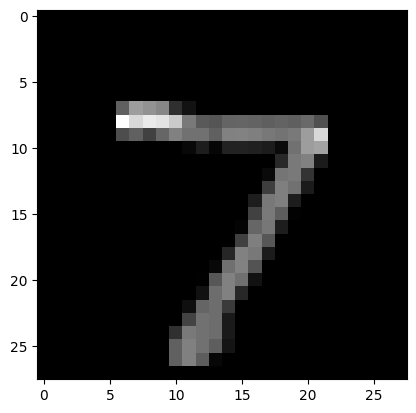

This value's label is:  7 


PREDICTION AT DATA INDEX: 1 --> 2


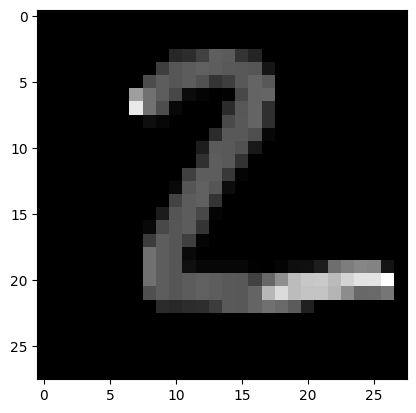

This value's label is:  2 


PREDICTION AT DATA INDEX: 5 --> 1


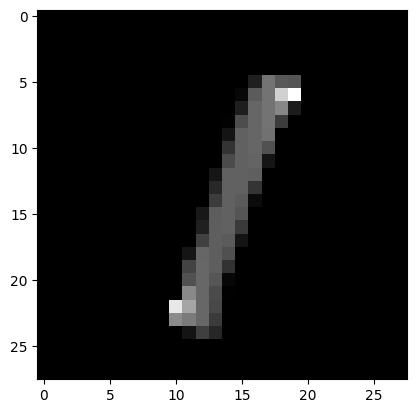

This value's label is:  1 


PREDICTION AT DATA INDEX: 10 --> 0


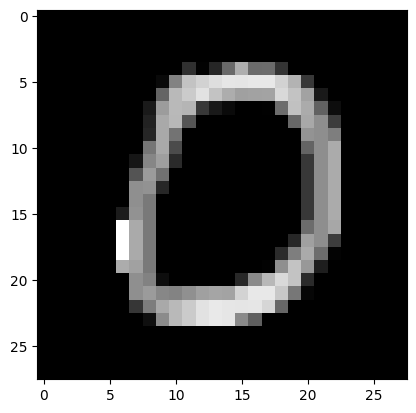

This value's label is:  0 


PREDICTION AT DATA INDEX: 11 --> 6


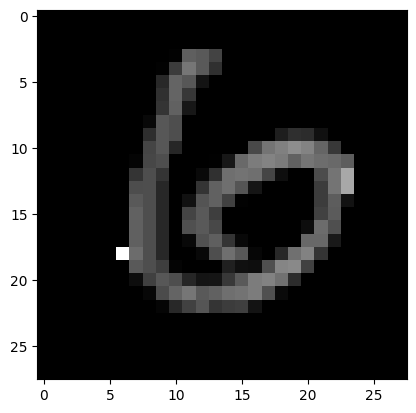

This value's label is:  6 


PREDICTION AT DATA INDEX: 12 --> 9


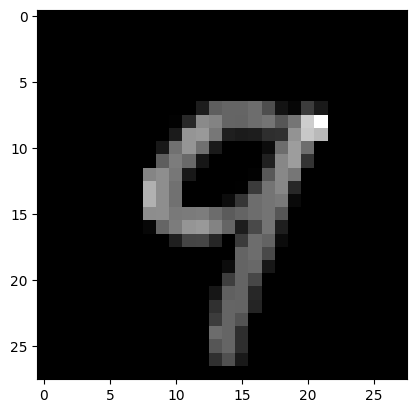

This value's label is:  9 




In [14]:
#Let's try and run some predictions

#This function makes it easy to display the model's prediction & the associated image it predicted on
def visual_prediction_check(predictions, data, y_data, index):

    #Display the model's prediction (in console)
    print("PREDICTION AT DATA INDEX:",str(index)+" -->", np.argmax(predictions[index]) )
    
    #Display the 28 x 28 img
    plt.imshow(data[index], cmap='gray')
    plt.show()
    print("This value's label is: ",np.argmax(y_data[index]),"\n\n")
    
    
#Making predictions on my Testing Dataset     
new_predictions = model.predict(X_test)    

#Calling my visual predictions function to check out some predictions the model made
visual_prediction_check(new_predictions, X_test, Y_test, 0)
visual_prediction_check(new_predictions, X_test, Y_test, 1)
visual_prediction_check(new_predictions, X_test, Y_test, 5)
visual_prediction_check(new_predictions, X_test, Y_test, 10)
visual_prediction_check(new_predictions, X_test, Y_test, 11)
visual_prediction_check(new_predictions, X_test, Y_test, 12)